In [2]:
#@title Choose seed value
Seed = 1995 #@param {type:"integer"}
!rm -rf ./logs/
%load_ext tensorboard
%matplotlib inline

import datetime
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

tf.random.set_seed(Seed)  # Seeding Tensorflow.
np.random.seed(Seed)  # Seeding Numpy.
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# MNIST Dataset - Loading & Preprocessing

In [3]:
num_classes = 10
img_rows, img_cols, img_colors = 28, 28, 1  # Greyscale images of 28 X 28.

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:,:,:,np.newaxis]
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:,:,:, np.newaxis]

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


#Classifiers For Investigation

In [4]:
def CNN_mnist_model(img_rows, img_cols, img_colors, num_classes, learning_rate,
                    name = "CNN"):
    activation = 'relu'
    model = keras.Sequential(name=name)
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(learning_rate),
                metrics=[keras.metrics.CategoricalAccuracy()])
    return model


def train_model(model, max_epochs: int, train_images, train_labels, test_images, 
                test_labels, batch_size, callbacks_list, verbose=1):
    history = model.fit(train_images, train_labels,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=verbose,
        validation_data=(test_images, test_labels),
        callbacks=callbacks_list)
    return history

def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

# Training The Classifier

In [5]:
#@title Select The Classifier to Attack and Hyperparameters
selected_model = "CNN from Lecture 2" #@param ["CNN from Lecture 2", "NN from Ex 1"]
batch_size = 128 #@param {type:"integer"}
max_epochs = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
lr_decay = 1e-6 #@param {type:"number"}
lr_drop = 6 #@param {type:"number"}


classifier = CNN_mnist_model(img_rows, img_cols, img_colors, 
                             num_classes, learning_rate)
print('Architecture of Classifier:')
classifier.summary()

callbacks_list = [reduce_lr]
print("Training the Classifier:")
classifier_history = train_model(classifier, max_epochs, X_train, 
                                 y_train, X_test, y_test, 
                                 batch_size, callbacks_list)

Architecture of Classifier:
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dropout_1 (Dropout)          (None,

# Images-Interpolation Stage

In [6]:
@tf.function
def interpolate_images(source_images: tf.Tensor, target_images: tf.Tensor, 
                       t: tf.Tensor):
  """
    Computing t*target_images + (1-t)*source_images for all images.

    Args:
      source_images - 4D float32 Tensor of [images_num, height, width, channels].
      target_images - 4D float32 Tensor of [images_num, height, width, channels].
      t - 1D float32 Tensor of time samples between 0 to 1.

    Returns:
      5D Tensor of [images_num, height, width, channels, time_samples].
  """
  new_axis: int = 4

  # Multiplying by t (note the minus sign over the target images).
  result = tf.tensordot(tf.stack(
      [-source_images, target_images], axis=new_axis), t, axes=0)
  
  # Summing -t * source_images + t * target_images
  result = tf.math.reduce_sum(result, axis=new_axis)

  # Adding source_images to the current sum. 
  repetitions = tf.concat([tf.ones(new_axis, dtype=tf.int32), 
                           tf.reshape(tf.size(t), [1])], axis=0)
  result = tf.math.add(tf.tile(tf.expand_dims(source_images, axis=new_axis), 
                               repetitions), result)
  return result

# Example of Image Interpolation

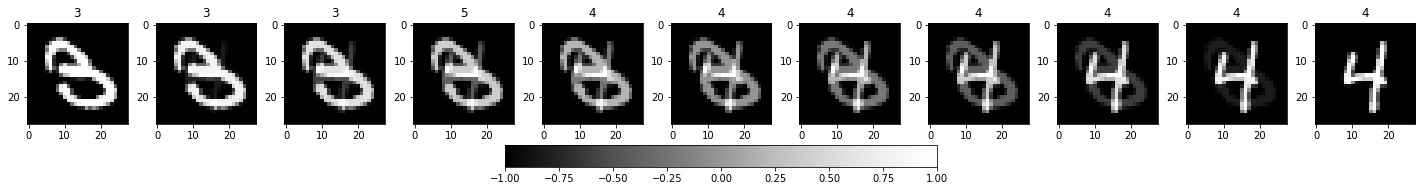

In [7]:
#@title Select Image-Interpolation samples number
samples_num = 11 #@param {type:"integer"}

def show_images(images: tf.Tensor, classifications: list):
  images_num: int = images.shape[0]  # Number of t values
  fig, axs = plt.subplots(1, images_num, figsize=(25, 25))  
  fig.subplots_adjust(bottom=0.8)
  for i in range(images_num):
    axs[i].set_title(classifications[i])
    pcm = axs[i].imshow(images[i, :, :, 0], cmap='Greys_r')

  fig.colorbar(pcm, ax=axs, location='bottom')
  plt.show()

t = tf.linspace(0.0, 1.0, samples_num)

# Using the same samples from the test-set as in the exercise file.
source_images = tf.Variable(X_test[18:20])
target_images = tf.Variable(X_test[19:21])

interpolated_images = interpolate_images(source_images, target_images, t)
interpolated_images = tf.transpose(interpolated_images, perm=[4, 0, 1, 2, 3])
interpolated_images = interpolated_images[:, 0, ...]  # Taking only a single image from the slice

classifications = classifier(interpolated_images)
classifications = np.argmax(classifications, axis=1)
show_images(interpolated_images.numpy(), classifications)

# Binary-Search Stage

In [8]:
def binary_search_lines(source_images: tf.Tensor, target_images: tf.Tensor, 
                        tol: tf.constant, source_classification: tf.constant,
                        target_classification: tf.constant, classifier):
  """

  Args:
    source_images - 4D float32 Tensor of [images_num, height, width, channels].
    target_images - 4D float32 Tensor of [images_num, height, width, channels].
    tol - 0D float32 constatnt (1e-7).
    classifications - 4D int32 Tensor of [images_num, height, width, channels].

  Returns:
    4D Tensor of [images_num, height, width, channels].
  """
  candidates = target_images.numpy()  # Deep-copy of these images.
  left_limit = source_images.numpy()
  right_limit = target_images.numpy()  # Deep-copy of these images.
  candidates_classifications = tf.argmax(classifier(target_images), axis=1).numpy()

  intervals_length = tf.math.reduce_sum(tf.square(
      tf.math.subtract(target_images, source_images)), axis=[1, 2, 3]).numpy()
  active_indices_bool = tf.math.greater_equal(intervals_length, tol).numpy()
  active_indices = tf.reshape(tf.where(active_indices_bool), [-1])

  while tf.math.reduce_any(active_indices_bool):
    # Classify the current candidates.
    candidates_classifications[active_indices_bool] = np.argmax(classifier(
        candidates[active_indices_bool, ...]), axis=1)

    # Finding indices where the candidate is classified differently than
    # the source images and the target images.
    boundary_indices = tf.logical_and(
        active_indices_bool, tf.logical_and(tf.math.not_equal(
            candidates_classifications, source_classification),
            tf.math.not_equal(candidates_classifications, 
                              target_classification)))
    # Removing the indices whose boundary was reached, from the active indices
    active_indices_bool = tf.logical_and(
        active_indices_bool, tf.logical_not(boundary_indices))

    # Calculate indices of pairs to move towards either source_images or target_images.
    active_indices = tf.reshape(tf.where(active_indices_bool), [-1]).numpy()
    
    move_to_target_indices = tf.reshape(tf.where(tf.logical_and(
        active_indices_bool, tf.math.equal(
            candidates_classifications, source_classification))), [-1])
    
    move_to_source_indices = tf.reshape(tf.where(tf.logical_and(
        active_indices_bool, tf.math.equal(
            candidates_classifications, target_classification))), [-1])

    left_limit[move_to_source_indices] = candidates[move_to_source_indices]
    right_limit[move_to_target_indices] = candidates[move_to_target_indices]

    candidates = tf.math.reduce_mean(tf.stack(
        [left_limit, right_limit], axis=4), axis=4).numpy()
    
    intervals_length[active_indices] /= 2
    
    active_indices_bool = tf.math.logical_and(
        active_indices_bool, tf.math.greater_equal(intervals_length, tol)).numpy()
    active_indices = tf.reshape(tf.where(active_indices_bool), [-1]).numpy()

    print(f'Active indices: {active_indices_bool}')
    print(f'Candidates classifications: {candidates_classifications}')
    print(f'Interval lengths: {intervals_length}')
  return candidates

# Example of Binary-Search Stage

In [9]:
tol = tf.constant(1e-7, dtype=tf.float32)

target_classifications = classifications[-1]
source_classifications = classifications[0]
binary_search_lines(source_images, target_images, tol, 
                    source_classifications, target_classifications, classifier);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [257.82654 340.0835 ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [128.91327 340.0835 ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [ 64.456635 340.0835  ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [ 32.228317 340.0835  ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [ 16.114159 340.0835  ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [  8.057079 340.0835  ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [  4.0285397 340.0835   ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [  2.0142698 340.0835   ]
Active indices: [ True False]
Candidates classifications: [4 9]
Interval lengths: [  1.0071349 340.0835   ]
Active indices: [ True False]
Candidates cla

#Gradient-Calculation Stage

In [39]:
@tf.function
def calc_gradient(x):
  with tf.GradientTape() as grad:
    # Calculate the maximal softmax value f_{target}(x)
    classifier_output = classifier(x)
    max_targets = tf.math.argmax(classifier_output, output_type=tf.int32, axis=1)
    idx = tf.stack([tf.range(x.shape[0]), max_targets], axis=-1)
    max_softmax = tf.gather_nd(classifier_output, idx)

    # Calculate the second maximal softmax value f_{i}(x) by turning
    # the elements in the maximal indices to zeroes.
    masked_output = tf.math.subtract(classifier_output, tf.scatter_nd(
        idx, max_softmax, classifier_output.shape))
    second_max = tf.math.reduce_max(masked_output, axis=1)

    # Computing the target value s(x) and its gradient.
    s = max_softmax - second_max  
    s_grads = grad.gradient(s, x)
    return s_grads

# Example of Gradient-Calculation Stage

In [42]:
x = source_images
y = calc_gradient(x)
print(f'x shape: {x.shape}')
print(f'ds/dx shape: {y.shape}')
print(f'ds/dx: {y}')

x shape: (2, 28, 28, 1)
ds/dx shape: (2, 28, 28, 1)
ds/dx: [[[[ 9.7529270e-04]
   [ 1.3987939e-03]
   [ 1.2073771e-03]
   ...
   [-6.8443891e-04]
   [ 3.0524970e-04]
   [ 0.0000000e+00]]

  [[ 8.6721289e-04]
   [-1.0216847e-03]
   [ 1.7212925e-04]
   ...
   [-2.5289301e-03]
   [-2.6791720e-03]
   [ 0.0000000e+00]]

  [[ 2.4240487e-03]
   [ 2.1969131e-03]
   [ 5.2733012e-03]
   ...
   [-6.5852061e-04]
   [-3.5681995e-04]
   [ 0.0000000e+00]]

  ...

  [[-2.6107251e-05]
   [-6.5874495e-04]
   [-5.1219598e-05]
   ...
   [-3.6262353e-03]
   [-1.9018163e-04]
   [-1.4601667e-05]]

  [[ 4.4731245e-05]
   [-1.6092788e-05]
   [ 6.0453918e-04]
   ...
   [-8.1205927e-04]
   [ 4.3623892e-04]
   [ 0.0000000e+00]]

  [[ 0.0000000e+00]
   [ 0.0000000e+00]
   [ 0.0000000e+00]
   ...
   [ 0.0000000e+00]
   [ 0.0000000e+00]
   [ 0.0000000e+00]]]


 [[[ 4.8892485e-05]
   [ 1.0516403e-05]
   [ 4.7610574e-06]
   ...
   [-5.1451239e-05]
   [-1.8466229e-05]
   [ 0.0000000e+00]]

  [[ 2.8333910e-05]
   [-9.01